In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('campeonato-brasileiro-full.csv')
df.head()

df.info()
df.describe()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7645 entries, 0 to 7644
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID                  7645 non-null   int64 
 1   rodada              7645 non-null   int64 
 2   data                7645 non-null   object
 3   hora                7645 non-null   object
 4   dia                 7645 non-null   object
 5   mandante            7645 non-null   object
 6   visitante           7645 non-null   object
 7   formacao_mandante   2671 non-null   object
 8   formacao_visitante  2671 non-null   object
 9   tecnico_mandante    3035 non-null   object
 10  tecnico_visitante   3035 non-null   object
 11  vencedor            7645 non-null   object
 12  arena               7645 non-null   object
 13  mandante_placar     7645 non-null   int64 
 14  visitante_placar    7645 non-null   int64 
 15  mandante_estado     7645 non-null   object
 16  visitante_estado    7645

ID                       0
rodada                   0
data                     0
hora                     0
dia                      0
mandante                 0
visitante                0
formacao_mandante     4974
formacao_visitante    4974
tecnico_mandante      4610
tecnico_visitante     4610
vencedor                 0
arena                    0
mandante_placar          0
visitante_placar         0
mandante_estado          0
visitante_estado         0
estado_vencedor          0
dtype: int64

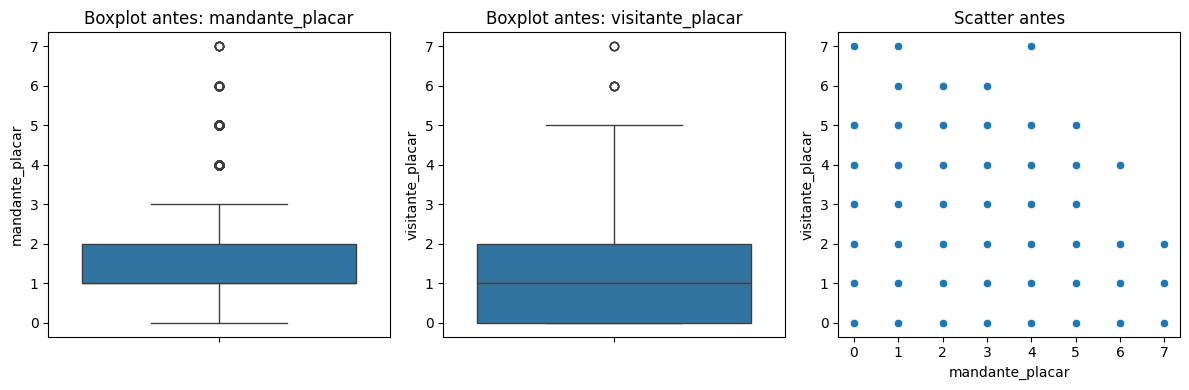

Resumo da remoção de outliers (método IQR):
mandante_placar: removidos=547 | limites=(-0.50, 3.50) | Q1=1.00 Q3=2.00
visitante_placar: removidos=7 | limites=(-3.00, 5.00) | Q1=0.00 Q3=2.00


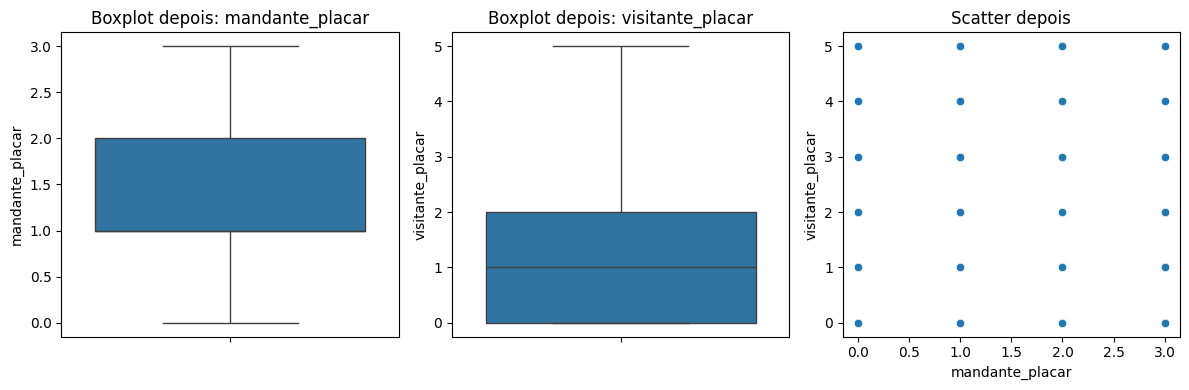

Correlação (Pearson) entre placares após limpeza: 0.043


In [86]:
# Análise de outliers para mandante_placar e visitante_placar usando IQR
cols = ['mandante_placar','visitante_placar']

# 1. Visualização inicial (boxplots + scatter)
fig, axes = plt.subplots(1, 3, figsize=(12,4))
for i, c in enumerate(cols):
    sns.boxplot(y=df[c], ax=axes[i])
    axes[i].set_title(f'Boxplot antes: {c}')
sns.scatterplot(data=df, x='mandante_placar', y='visitante_placar', ax=axes[2])
axes[2].set_title('Scatter antes')
plt.tight_layout()
plt.show()

# 2. Função para filtrar outliers via IQR
def iqr_filter(frame, column, k=1.5):
    Q1 = frame[column].quantile(0.25)
    Q3 = frame[column].quantile(0.75)
    IQR = Q3 - Q1
    low = Q1 - k * IQR
    high = Q3 + k * IQR
    mask = (frame[column] >= low) & (frame[column] <= high)
    removed = (~mask).sum()
    return frame[mask], {
        'col': column,
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'low': low,
        'high': high,
        'removed': removed
    }

stats = []
df_clean = df.copy()
for c in cols:
    df_clean, st = iqr_filter(df_clean, c)
    stats.append(st)

print('Resumo da remoção de outliers (método IQR):')
for st in stats:
    print(f"{st['col']}: removidos={st['removed']} | limites=({st['low']:.2f}, {st['high']:.2f}) | Q1={st['Q1']:.2f} Q3={st['Q3']:.2f}")

# 3. Visualização após limpeza
fig, axes = plt.subplots(1, 3, figsize=(12,4))
for i, c in enumerate(cols):
    sns.boxplot(y=df_clean[c], ax=axes[i])
    axes[i].set_title(f'Boxplot depois: {c}')
sns.scatterplot(data=df_clean, x='mandante_placar', y='visitante_placar', ax=axes[2])
axes[2].set_title('Scatter depois')
plt.tight_layout()
plt.show()

# 4. Correlação
corr = df_clean['mandante_placar'].corr(df_clean['visitante_placar'])
print(f"Correlação (Pearson) entre placares após limpeza: {corr:.3f}")

# 5. Atualiza df principal
df = df_clean

# Observação: ajuste k na função iqr_filter (ex.: k=3) se quiser ser mais conservador na remoção.

Contagem de possíveis outliers por coluna (|z|>3):
mandante_placar      0
visitante_placar    19
rodada               0
dtype: int64
Colunas categóricas de baixa cardinalidade selecionadas para one-hot: ['dia', 'mandante_estado', 'visitante_estado']
Matriz de correlação (valores numéricos):
                  mandante_placar  visitante_placar  gols_totais  saldo_gols  \
mandante_placar          1.000000          0.043370     0.708269    0.675647   
visitante_placar         0.043370          1.000000     0.735996   -0.707228   
gols_totais              0.708269          0.735996     1.000000   -0.041898   
saldo_gols               0.675647         -0.707228    -0.041898    1.000000   
rodada                   0.020513         -0.004733     0.010555    0.018009   

                    rodada  
mandante_placar   0.020513  
visitante_placar -0.004733  
gols_totais       0.010555  
saldo_gols        0.018009  
rodada            1.000000  


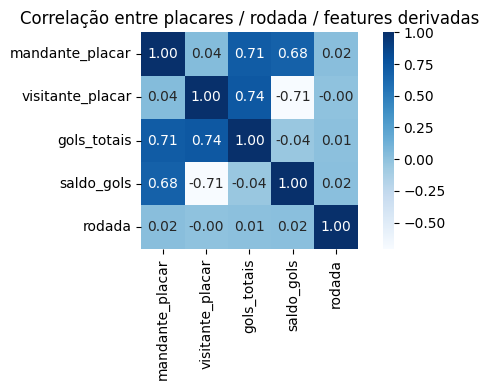

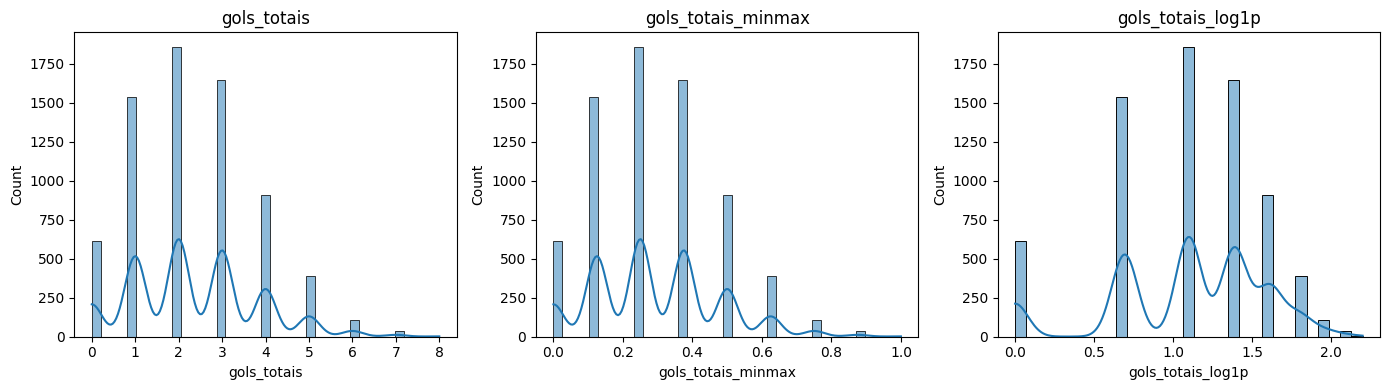

Shape original: (7091, 22) | Shape codificada: (7091, 53)


In [87]:
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

# 1. Escolher colunas numéricas relevantes
numeric_cols = ['mandante_placar','visitante_placar']
if 'rodada' in df.columns:
    numeric_cols.append('rodada')

num_df = df[numeric_cols].copy()

# 2. Z-score (para cada coluna numérica)
z_scores = num_df.apply(lambda s: stats.zscore(s, nan_policy='omit'))
z_flag = (z_scores.abs() > 3)  # boolean indicating potential outliers
print('Contagem de possíveis outliers por coluna (|z|>3):')
print(z_flag.sum())

# 3. Feature engineering: gols totais e diferença de gols
if all(c in df.columns for c in ['mandante_placar','visitante_placar']):
    df['gols_totais'] = df['mandante_placar'] + df['visitante_placar']
    df['saldo_gols'] = df['mandante_placar'] - df['visitante_placar']

# 4. Normalização Min-Max e Log1p para gols_totais
scaler = MinMaxScaler()
if 'gols_totais' in df.columns:
    df['gols_totais_minmax'] = scaler.fit_transform(df[['gols_totais']])
    df['gols_totais_log1p'] = np.log1p(df['gols_totais'])

# 5. Codificação de variáveis categóricas (exemplos comuns do dataset)
# Vamos detectar automaticamente algumas colunas categóricas de baixo cardinalidade
potential_cat = [c for c in df.columns if df[c].dtype == 'object']
low_card_cat = [c for c in potential_cat if df[c].nunique() <= 15]  # limite arbitrário
print('Colunas categóricas de baixa cardinalidade selecionadas para one-hot:', low_card_cat)

# One-hot encoding controlado
df_encoded = pd.get_dummies(df, columns=low_card_cat, drop_first=True)

# 6. Matriz de correlação entre placares, rodada e novas features
corr_cols = [c for c in ['mandante_placar','visitante_placar','gols_totais','saldo_gols','rodada'] if c in df_encoded.columns]

corr_matrix = df_encoded[corr_cols].corr()
print('Matriz de correlação (valores numéricos):')
print(corr_matrix)

plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt='.2f', square=True)
plt.title('Correlação entre placares / rodada / features derivadas')
plt.tight_layout()
plt.show()

# 7. Visual comparativa distribuições (original vs transformada) se gols_totais criado
if 'gols_totais' in df.columns:
    fig, axes = plt.subplots(1,3, figsize=(14,4))
    sns.histplot(df['gols_totais'], kde=True, ax=axes[0])
    axes[0].set_title('gols_totais')
    sns.histplot(df['gols_totais_minmax'], kde=True, ax=axes[1])
    axes[1].set_title('gols_totais_minmax')
    sns.histplot(df['gols_totais_log1p'], kde=True, ax=axes[2])
    axes[2].set_title('gols_totais_log1p')
    plt.tight_layout()
    plt.show()

# Atualiza df principal para versão codificada se necessário
# (Se quiser manter apenas numéricas + dummies):
# df = df_encoded

print('Shape original:', df.shape, '| Shape codificada:', df_encoded.shape)


In [88]:
# 1. Conversão de datas e features derivadas
possible_date_cols = [c for c in df.columns if 'data' in c.lower() or 'date' in c.lower()]
print('Possíveis colunas de data encontradas:', possible_date_cols)

for c in possible_date_cols:
    try:
        df[c] = pd.to_datetime(df[c], errors='coerce', dayfirst=True)
    except Exception as e:
        print(f'Falha ao converter {c}:', e)

# Criar colunas derivadas para a primeira coluna de data válida
if possible_date_cols:
    date_col = possible_date_cols[0]
    if pd.api.types.is_datetime64_any_dtype(df[date_col]):
        df['ano'] = df[date_col].dt.year
        df['mes'] = df[date_col].dt.month
        df['dia_semana'] = df[date_col].dt.day_name(locale='pt_BR') if hasattr(df[date_col].dt, 'day_name') else df[date_col].dt.dayofweek
        print(f'Colunas derivadas criadas a partir de {date_col}.')
    else:
        print('Nenhuma coluna de data válida para derivação.')
else:
    print('Nenhuma coluna potencial de data encontrada.')

Possíveis colunas de data encontradas: ['data']
Colunas derivadas criadas a partir de data.


C:\Users\joaoa\AppData\Local\Temp\ipykernel_32076\3437873969.py:7: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df[c] = pd.to_datetime(df[c], errors='coerce', dayfirst=True)


In [89]:
# 2. Funções de filtragem por time mandante/visitante ou árbitro

def filtrar(df_base, mandante=None, visitante=None, arbitro=None):
    dff = df_base.copy()
    if mandante and 'mandante' in dff.columns:
        dff = dff[dff['mandante'] == mandante]
    if visitante and 'visitante' in dff.columns:
        dff = dff[dff['visitante'] == visitante]
    if arbitro and ('arbitro' in dff.columns or 'árbitro' in dff.columns):
        arb_col = 'arbitro' if 'arbitro' in dff.columns else 'árbitro'
        dff = dff[dff[arb_col] == arbitro]
    return dff

# 3. Lista de valores únicos para auxiliar seleção manual
for col in ['mandante','visitante','arbitro','árbitro']:
    if col in df.columns:
        print(f'Valores únicos em {col} (primeiros 15):', df[col].dropna().unique()[:15])

# Exemplo de uso (ajuste manualmente os nomes reais):
exemplo_df = filtrar(df, mandante=None, visitante=None, arbitro=None)
print('Registros após filtro de exemplo:', len(exemplo_df))

Valores únicos em mandante (primeiros 15): ['Athletico-PR' 'Flamengo' 'Goias' 'Internacional' 'Criciuma' 'Juventude'
 'Fortaleza' 'Cruzeiro' 'Vitoria' 'Santos' 'Corinthians' 'Fluminense'
 'Atletico-MG' 'Coritiba' 'Gremio']
Valores únicos em visitante (primeiros 15): ['Gremio' 'Coritiba' 'Paysandu' 'Ponte Preta' 'Fluminense' 'Sao Paulo'
 'Bahia' 'Sao Caetano' 'Figueirense' 'Parana' 'Atletico-MG' 'Fortaleza'
 'Santos' 'Internacional' 'Guarani']
Registros após filtro de exemplo: 7091


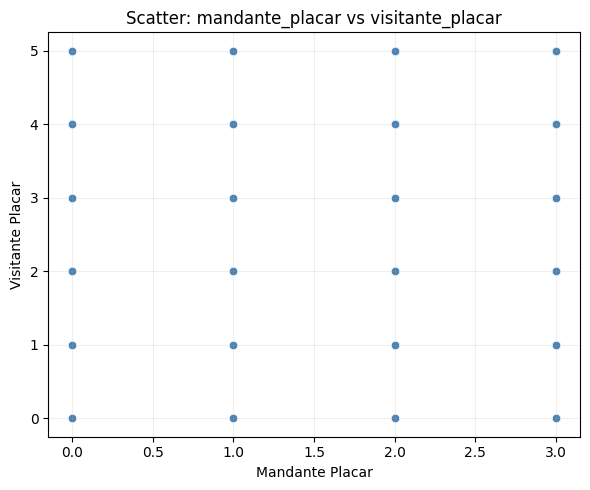

In [90]:
# 4. Função para scatter plot filtrado

def scatter_placares(df_base, mandante=None, visitante=None, arbitro=None, hue=None):
    dff = filtrar(df_base, mandante, visitante, arbitro)
    if dff.empty:
        print('Nenhum registro após filtros.')
        return
    plt.figure(figsize=(6,5))
    if hue and hue in dff.columns:
        sns.scatterplot(data=dff, x='mandante_placar', y='visitante_placar', hue=hue, palette='tab10')
    else:
        sns.scatterplot(data=dff, x='mandante_placar', y='visitante_placar', color='steelblue')
    plt.title('Scatter: mandante_placar vs visitante_placar')
    plt.xlabel('Mandante Placar')
    plt.ylabel('Visitante Placar')
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()

# Exemplo simples (sem filtros):
scatter_placares(df)


In [91]:
# 5. (Opcional) Widgets interativos se ipywidgets estiver instalado
try:
    import ipywidgets as widgets
    from IPython.display import display
    mandantes = sorted(df['mandante'].dropna().unique()) if 'mandante' in df.columns else []
    visitantes = sorted(df['visitante'].dropna().unique()) if 'visitante' in df.columns else []
    arbitros = sorted(df['arbitro'].dropna().unique()) if 'arbitro' in df.columns else (sorted(df['árbitro'].dropna().unique()) if 'árbitro' in df.columns else [])

    mandante_w = widgets.Dropdown(options=[''] + mandantes, description='Mandante:')
    visitante_w = widgets.Dropdown(options=[''] + visitantes, description='Visitante:')
    arbitro_w = widgets.Dropdown(options=[''] + arbitros, description='Árbitro:')
    hue_w = widgets.Dropdown(options=[''] + [c for c in ['ano','mes','rodada'] if c in df.columns], description='Hue:')
    out_box = widgets.Output()

    def update_plot(*args):
        out_box.clear_output()
        with out_box:
            scatter_placares(df,
                             mandante=mandante_w.value or None,
                             visitante=visitante_w.value or None,
                             arbitro=arbitro_w.value or None,
                             hue=hue_w.value or None)

    for w in [mandante_w, visitante_w, arbitro_w, hue_w]:
        w.observe(update_plot, names='value')

    display(widgets.HBox([mandante_w, visitante_w]))
    display(widgets.HBox([arbitro_w, hue_w]))
    display(out_box)
    update_plot()
except ImportError:
    print('ipywidgets não instalado - pulei interface interativa.')

ipywidgets não instalado - pulei interface interativa.


In [92]:
# 6. Exportação do dataframe final tratado
output_filename = 'campeonato-brasileiro-tratado.csv'
df.to_csv(output_filename, index=False, encoding='utf-8')
print(f'Dataframe exportado para {output_filename} (linhas={len(df)})')

Dataframe exportado para campeonato-brasileiro-tratado.csv (linhas=7091)


In [93]:
# 1. Colunas derivadas de resultado
required_cols = {'mandante','visitante','mandante_placar','visitante_placar'}
if required_cols.issubset(set(df.columns)):
    df['resultado'] = np.where(df['mandante_placar'] > df['visitante_placar'], 'mandante',
                        np.where(df['mandante_placar'] < df['visitante_placar'], 'visitante', 'empate'))
    df['vencedor'] = np.where(df['resultado'] == 'empate', 'empate',
                       np.where(df['resultado'] == 'mandante', df['mandante'], df['visitante']))
    print('Colunas resultado e vencedor criadas.')
else:
    print('Não foi possível criar colunas de resultado: faltam colunas necessárias.')

# 2. Número de vitórias por time (considerando mandante e visitante)
if 'vencedor' in df.columns:
    vitorias = df[df['vencedor'] != 'empate'].groupby('vencedor').size().rename('vitorias').to_frame()
else:
    vitorias = pd.DataFrame()

# 3. Empates por time (cada time que participou do empate conta 1)
if 'resultado' in df.columns and 'mandante' in df.columns and 'visitante' in df.columns:
    empates_mand = df[df['resultado']=='empate'].groupby('mandante').size()
    empates_visit = df[df['resultado']=='empate'].groupby('visitante').size()
    empates = (empates_mand.add(empates_visit, fill_value=0)).rename('empates')
else:
    empates = pd.Series(dtype='int64')

# 4. Jogos disputados por time
if {'mandante','visitante'}.issubset(df.columns):
    jogos_mand = df.groupby('mandante').size()
    jogos_visit = df.groupby('visitante').size()
    jogos = jogos_mand.add(jogos_visit, fill_value=0).rename('jogos')
else:
    jogos = pd.Series(dtype='int64')

# 5. Gols pró e contra por time
if required_cols.issubset(df.columns):
    gols_pro_mand = df.groupby('mandante')['mandante_placar'].sum()
    gols_pro_visit = df.groupby('visitante')['visitante_placar'].sum()
    gols_pro = gols_pro_mand.add(gols_pro_visit, fill_value=0).rename('gols_pro')

    gols_contra_mand = df.groupby('mandante')['visitante_placar'].sum()
    gols_contra_visit = df.groupby('visitante')['mandante_placar'].sum()
    gols_contra = gols_contra_mand.add(gols_contra_visit, fill_value=0).rename('gols_contra')
else:
    gols_pro = pd.Series(dtype='int64')
    gols_contra = pd.Series(dtype='int64')

# 6. Montagem do dataframe agregado
agregados = pd.concat([jogos, vitorias, empates, gols_pro, gols_contra], axis=1)
agregados.fillna(0, inplace=True)
if 'vitorias' in agregados.columns:
    agregados['taxa_vitoria'] = agregados['vitorias'] / agregados['jogos'].replace(0, np.nan)
if {'gols_pro','gols_contra'}.issubset(agregados.columns):
    agregados['saldo_gols_time'] = agregados['gols_pro'] - agregados['gols_contra']

agregados.sort_values(by='vitorias', ascending=False, inplace=True)
print('Resumo agregados (top 10):')
print(agregados.head(10))


Colunas resultado e vencedor criadas.
Resumo agregados (top 10):
               jogos  vitorias  empates  gols_pro  gols_contra  taxa_vitoria  \
Sao Paulo        696       308      203       905          708      0.442529   
Flamengo         682       286      203       879          723      0.419355   
Santos           685       280      195       897          748      0.408759   
Internacional    668       279      179       823          698      0.417665   
Corinthians      676       276      204       808          685      0.408284   
Atletico-MG      649       263      176       872          774      0.405239   
Fluminense       699       262      197       850          819      0.374821   
Gremio           645       262      179       773          653      0.406202   
Cruzeiro         610       258      150       786          684      0.422951   
Palmeiras        614       254      168       796          686      0.413681   

               saldo_gols_time  
Sao Paulo            

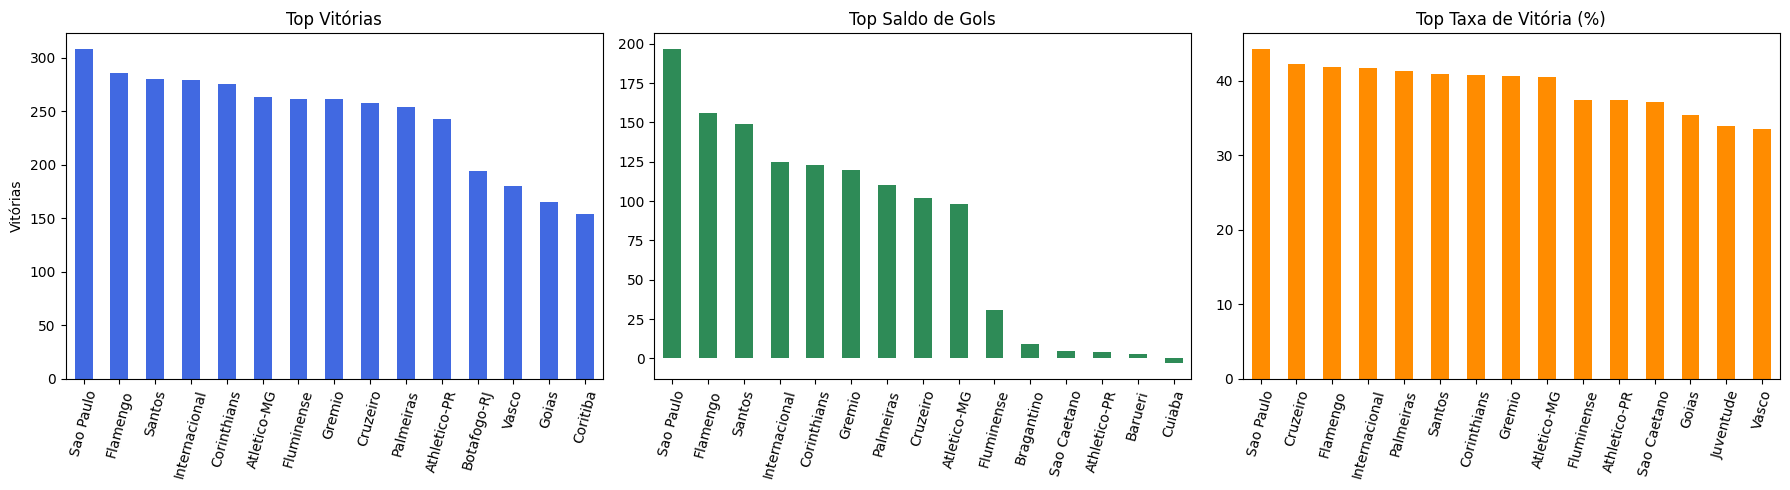

In [94]:
# 7. Gráficos de barras (Top N)
if not agregados.empty:
    top_n = 15
    fig, axes = plt.subplots(1,3, figsize=(18,5))

    # Vitórias
    agregados.nlargest(top_n, 'vitorias')['vitorias'].plot(kind='bar', ax=axes[0], color='royalblue')
    axes[0].set_title('Top Vitórias')
    axes[0].set_ylabel('Vitórias')

    # Saldo de gols
    if 'saldo_gols_time' in agregados.columns:
        agregados.nlargest(top_n, 'saldo_gols_time')['saldo_gols_time'].plot(kind='bar', ax=axes[1], color='seagreen')
        axes[1].set_title('Top Saldo de Gols')

    # Taxa de vitória
    if 'taxa_vitoria' in agregados.columns:
        (agregados['taxa_vitoria']*100).nlargest(top_n).plot(kind='bar', ax=axes[2], color='darkorange')
        axes[2].set_title('Top Taxa de Vitória (%)')

    for ax in axes:
        ax.tick_params(axis='x', rotation=75)
    plt.tight_layout()
    plt.show()
else:
    print('Dados agregados vazios, não gerando gráficos.')

Correlação entre métricas agregadas:
                    jogos  vitorias   empates  gols_pro  gols_contra  \
jogos            1.000000  0.987791  0.992243  0.994680     0.991311   
vitorias         0.987791  1.000000  0.976015  0.995583     0.963606   
empates          0.992243  0.976015  1.000000  0.984575     0.980375   
gols_pro         0.994680  0.995583  0.984575  1.000000     0.981168   
gols_contra      0.991311  0.963606  0.980375  0.981168     1.000000   
saldo_gols_time  0.643178  0.749019  0.639828  0.703451     0.552918   
taxa_vitoria     0.834698  0.857527  0.821999  0.849294     0.806231   

                 saldo_gols_time  taxa_vitoria  
jogos                   0.643178      0.834698  
vitorias                0.749019      0.857527  
empates                 0.639828      0.821999  
gols_pro                0.703451      0.849294  
gols_contra             0.552918      0.806231  
saldo_gols_time         1.000000      0.697041  
taxa_vitoria            0.697041      1.000

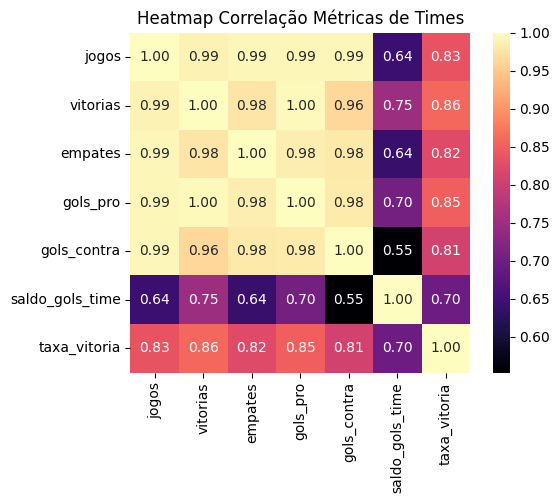

In [95]:
# 8. Heatmap de correlação entre métricas agregadas
if not agregados.empty:
    metric_cols = [c for c in ['jogos','vitorias','empates','gols_pro','gols_contra','saldo_gols_time','taxa_vitoria'] if c in agregados.columns]
    corr_ag = agregados[metric_cols].corr()
    print('Correlação entre métricas agregadas:')
    print(corr_ag)
    plt.figure(figsize=(6,5))
    sns.heatmap(corr_ag, annot=True, cmap='magma', fmt='.2f', square=True)
    plt.title('Heatmap Correlação Métricas de Times')
    plt.tight_layout()
    plt.show()
else:
    print('Sem dados agregados para correlação.')

In [96]:
# Preparação dos dados para o Bet Simulator (atualizado com median fill + heuristic always)
from collections import defaultdict
try:
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.linear_model import LogisticRegression
    from sklearn.pipeline import Pipeline
    from sklearn.compose import ColumnTransformer
    from sklearn.impute import SimpleImputer
    SKLEARN_OK = True
except ImportError:
    SKLEARN_OK = False
    print('scikit-learn não instalado. Usarei heurística simples.')

# Garantir colunas necessárias
needed = {'mandante','visitante','mandante_placar','visitante_placar'}
if not needed.issubset(df.columns):
    print('Colunas necessárias ausentes para simulador.')
else:
    # Criar label H=mandante, D=empate, A=visitante
    df['match_outcome'] = np.where(df['mandante_placar'] > df['visitante_placar'], 'H',
                            np.where(df['mandante_placar'] < df['visitante_placar'], 'A', 'D'))

    feature_cols_cat = [c for c in ['mandante','visitante'] if c in df.columns]
    feature_cols_num = [c for c in ['rodada','ano','gols_totais','saldo_gols'] if c in df.columns]

    X = df[feature_cols_cat + feature_cols_num].copy()
    y = df['match_outcome']

    # Guardar medianas para uso em predição manual
    NUM_MEDIANS = {c: X[c].median() for c in feature_cols_num}

    MODEL = None
    MODEL_TYPE = None
    if SKLEARN_OK and len(y.unique()) == 3:
        transformers = []
        if feature_cols_cat:
            transformers.append(('team_ohe', OneHotEncoder(handle_unknown='ignore'), feature_cols_cat))
        if feature_cols_num:
            transformers.append(('num_imp', SimpleImputer(strategy='median'), feature_cols_num))
        ct = ColumnTransformer(transformers, remainder='drop')
        model = Pipeline([
            ('prep', ct),
            ('clf', LogisticRegression(max_iter=300, multi_class='auto'))
        ])
        try:
            model.fit(X, y)
            MODEL = model
            MODEL_TYPE = 'logreg'
            print('Modelo LogisticRegression treinado (baseline) com imputação de medianas.')
        except Exception as e:
            print('Falha no treino logreg, usaremos apenas heurística. Motivo:', e)
            MODEL = None
            MODEL_TYPE = None

    # Sempre construir heurística para fallback
    stats_team = defaultdict(lambda: {'jogos':0,'vitorias':0,'derrotas':0,'empates':0,'gols_pro':0,'gols_contra':0})
    for _, r in df.iterrows():
        m = r['mandante']; v = r['visitante']
        gp_m = r['mandante_placar']; gp_v = r['visitante_placar']
        stats_team[m]['jogos'] += 1; stats_team[v]['jogos'] += 1
        stats_team[m]['gols_pro'] += gp_m; stats_team[m]['gols_contra'] += gp_v
        stats_team[v]['gols_pro'] += gp_v; stats_team[v]['gols_contra'] += gp_m
        if gp_m > gp_v:
            stats_team[m]['vitorias'] += 1; stats_team[v]['derrotas'] += 1
        elif gp_m < gp_v:
            stats_team[v]['vitorias'] += 1; stats_team[m]['derrotas'] += 1
        else:
            stats_team[m]['empates'] += 1; stats_team[v]['empates'] += 1
    HEURISTIC_MODEL = {'stats': stats_team}
    print('Heuristic stats prontas para fallback.')

c:\ProgramData\mambaforge\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\ProgramData\mambaforge\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Modelo LogisticRegression treinado (baseline) com imputação de medianas.
Heuristic stats prontas para fallback.


In [97]:
# Funções de predição e simulação de aposta (auto-fallback)
import math

def _heuristic_probs(model_dict, mandante, visitante):
    stats = model_dict['stats']
    def team_metrics(t):
        s = stats.get(t, {'jogos':0,'vitorias':0,'empates':0,'derrotas':0,'gols_pro':0,'gols_contra':0})
        jogos = s['jogos'] if s['jogos'] else 1
        win_rate = s['vitorias']/jogos
        draw_rate = s['empates']/jogos
        avg_gols_pro = s['gols_pro']/jogos
        avg_gols_contra = s['gols_contra']/jogos
        saldo = avg_gols_pro - avg_gols_contra
        return win_rate, draw_rate, saldo
    w_m, d_m, saldo_m = team_metrics(mandante)
    w_v, d_v, saldo_v = team_metrics(visitante)
    home_strength = w_m + 0.15 + 0.05*saldo_m
    away_strength = w_v + 0.05*saldo_v
    draw_component = (d_m + d_v)/2 * 0.9
    raw_home = max(home_strength, 0.01)
    raw_away = max(away_strength, 0.01)
    raw_draw = max(draw_component, 0.01)
    total = raw_home + raw_away + raw_draw
    return {'H': raw_home/total,'D': raw_draw/total,'A': raw_away/total}

def prever_partida(mandante, visitante, rodada=None, ano=None, odds_casa=None, force_heuristic=False):
    has_logreg = ('MODEL' in globals() and MODEL is not None and 'MODEL_TYPE' in globals() and MODEL_TYPE == 'logreg')
    usar_heuristica = force_heuristic or not has_logreg
    if has_logreg and not force_heuristic:
        # verificar se times existem no histórico (evitar one-hot sem colunas)
        if not ((mandante in df['mandante'].values) or (mandante in df['visitante'].values)):
            usar_heuristica = True
        if not ((visitante in df['mandante'].values) or (visitante in df['visitante'].values)):
            usar_heuristica = True
    if usar_heuristica:
        probs = _heuristic_probs(HEURISTIC_MODEL, mandante, visitante)
    else:
        cols_used = [c for c in X.columns]
        sample = {}
        for c in cols_used:
            if c == 'mandante': sample[c] = mandante
            elif c == 'visitante': sample[c] = visitante
            elif c == 'rodada': sample[c] = rodada if rodada is not None else NUM_MEDIANS.get('rodada', 0)
            elif c == 'ano': sample[c] = ano if ano is not None else NUM_MEDIANS.get('ano', 0)
            else:  # gols_totais / saldo_gols etc.
                sample[c] = NUM_MEDIANS.get(c, 0)
        df_in = pd.DataFrame([sample])
        probs_arr = MODEL.predict_proba(df_in)[0]
        classes = list(MODEL.classes_)
        probs = {cls: probs_arr[i] for i, cls in enumerate(classes)}
    for k in ['H','D','A']:
        probs.setdefault(k, 0.0)
    soma = sum(probs.values()) or 1.0
    probs = {k: v/soma for k,v in probs.items()}
    fair_odds = {k: 1/v if v>0 else math.inf for k,v in probs.items()}
    print(f'Probabilidades estimadas: Casa(H)={probs["H"]:.3f} Empate(D)={probs["D"]:.3f} Visitante(A)={probs["A"]:.3f}')
    print(f'Odds justas (~): H={fair_odds["H"]:.2f} D={fair_odds["D"]:.2f} A={fair_odds["A"]:.2f}')
    if odds_casa:
        evs = {k: probs[k]*odds_casa.get(k, 0) - 1 for k in ['H','D','A'] if odds_casa.get(k) is not None}
        print('Valor Esperado (EV):')
        for k,v in evs.items():
            print(f'{k}: EV={v:.3f}')
    return probs, fair_odds

# Atalho para forçar heurística
def prever_partida_heuristica(mandante, visitante, rodada=None, ano=None, odds_casa=None):
    return prever_partida(mandante, visitante, rodada=rodada, ano=ano, odds_casa=odds_casa, force_heuristic=True)

In [98]:
# Widgets (opcional) para interação com Bet Simulator
try:
    import ipywidgets as widgets
    if {'mandante','visitante'}.issubset(df.columns):
        times = sorted(set(df['mandante'].dropna().unique()).union(set(df['visitante'].dropna().unique())))
        mand_w = widgets.Dropdown(options=times, description='Mandante:')
        visit_w = widgets.Dropdown(options=times, description='Visitante:')
        rodada_w = widgets.IntText(value=None, description='Rodada:')
        ano_w = widgets.IntText(value=None, description='Ano:')
        odd_h = widgets.FloatText(value=None, description='Odd H:')
        odd_d = widgets.FloatText(value=None, description='Odd D:')
        odd_a = widgets.FloatText(value=None, description='Odd A:')
        outp = widgets.Output()

        def run_pred(_):
            outp.clear_output()
            with outp:
                odds_dict = {'H': odd_h.value, 'D': odd_d.value, 'A': odd_a.value}
                prever_partida(mand_w.value, visit_w.value,
                               rodada=rodada_w.value if rodada_w.value else None,
                               ano=ano_w.value if ano_w.value else None,
                               odds_casa=odds_dict)
        btn = widgets.Button(description='Simular')
        btn.on_click(run_pred)
        display(widgets.HBox([mand_w, visit_w]))
        display(widgets.HBox([rodada_w, ano_w]))
        display(widgets.HBox([odd_h, odd_d, odd_a]))
        display(btn, outp)
    else:
        print('Colunas de times não disponíveis para widgets.')
except ImportError:
    print('ipywidgets não instalado para interface interativa do Bet Simulator.')

ipywidgets não instalado para interface interativa do Bet Simulator.


### Exemplos Reais (23 Ago 2025) para Testar o Bet Simulator

Partidas e odds fornecidas:
1. RB Bragantino vs Fluminense — Odds: H=2.42, D=3.05, A=3.25
2. Cruzeiro MG vs Internacional RS — Odds: H=1.77, D=3.30, A=5.50
3. Grêmio RS vs Ceará — Odds: H=2.07, D=3.10, A=4.00

Observação: O nome dos times no dataset pode diferir (ex.: "RB Bragantino" vs "Bragantino"). Incluímos uma função simples de normalização/mapeamento.

In [99]:
# Execução de testes com partidas reais fornecidas (atualizado)
team_name_map = {
    'RB Bragantino': 'Bragantino',
    'Grêmio RS': 'Grêmio',
    'Internacional RS': 'Internacional',
    'Cruzeiro MG': 'Cruzeiro'
}

def map_team(t):
    return team_name_map.get(t, t)

exemplos = [
    {'mandante': 'RB Bragantino', 'visitante': 'Fluminense', 'odds': {'H': 2.42, 'D': 3.05, 'A': 3.25}, 'rodada': None, 'ano': None},
    {'mandante': 'Cruzeiro MG', 'visitante': 'Internacional RS', 'odds': {'H': 1.77, 'D': 3.30, 'A': 5.50}, 'rodada': None, 'ano': None},
    {'mandante': 'Grêmio RS', 'visitante': 'Ceará', 'odds': {'H': 2.07, 'D': 3.10, 'A': 4.00}, 'rodada': None, 'ano': None},
]

for ex in exemplos:
    m = map_team(ex['mandante'])
    v = map_team(ex['visitante'])
    print('\n====', ex['mandante'], 'vs', ex['visitante'], '====')
    # Se algum time não estiver no dataset treinado e modelo for logreg, forçar heurística
    if 'MODEL_TYPE' in globals() and MODEL_TYPE == 'logreg':
        if m not in df['mandante'].values and m not in df['visitante'].values:
            print(f'Time {m} não encontrado no histórico — usando heurística.')
            MODEL_TYPE = 'heuristic'
        if v not in df['mandante'].values and v not in df['visitante'].values:
            print(f'Time {v} não encontrado no histórico — usando heurística.')
            MODEL_TYPE = 'heuristic'
    prever_partida(m, v, rodada=ex['rodada'], ano=ex['ano'], odds_casa=ex['odds'])


==== RB Bragantino vs Fluminense ====
Probabilidades estimadas: Casa(H)=0.005 Empate(D)=0.990 Visitante(A)=0.005
Odds justas (~): H=197.98 D=1.01 A=188.98
Valor Esperado (EV):
H: EV=-0.988
D: EV=2.018
A: EV=-0.983

==== Cruzeiro MG vs Internacional RS ====
Probabilidades estimadas: Casa(H)=0.005 Empate(D)=0.990 Visitante(A)=0.005
Odds justas (~): H=188.76 D=1.01 A=193.07
Valor Esperado (EV):
H: EV=-0.991
D: EV=2.265
A: EV=-0.972

==== Grêmio RS vs Ceará ====
Time Grêmio não encontrado no histórico — usando heurística.
Time Ceará não encontrado no histórico — usando heurística.
Probabilidades estimadas: Casa(H)=0.882 Empate(D)=0.059 Visitante(A)=0.059
Odds justas (~): H=1.13 D=17.00 A=17.00
Valor Esperado (EV):
H: EV=0.826
D: EV=-0.818
A: EV=-0.765


In [100]:
# Exemplos adicionais - Jogos 24 Ago 2025
jogos_24 = [
    ('Vasco', 'Corinthians', {'H':2.30,'D':3.10,'A':3.20}),
    ('Bahia', 'Santos', {'H':2.05,'D':3.25,'A':3.60}),
    ('Fortaleza', 'Mirassol', {'H':1.85,'D':3.30,'A':4.20}),
    ('Juventude', 'Botafogo RJ', {'H':2.95,'D':3.05,'A':2.45}),
    ('São Paulo', 'Atlético MG', {'H':2.50,'D':3.00,'A':2.95}),
]
print('\n=== Jogos 24/08/2025 ===')
for mand, vist, odds in jogos_24:
    print(f'\n{mand} vs {vist}')
    try:
        prever_partida(mand, vist, rodada=None, ano=2025, odds_casa=odds)
    except Exception as e:
        print('Erro (tentando heurística):', e)
        try:
            prever_partida_heuristica(mand, vist, rodada=None, ano=2025, odds_casa=odds)
        except Exception as e2:
            print('Falhou também na heurística:', e2)


=== Jogos 24/08/2025 ===

Vasco vs Corinthians
Probabilidades estimadas: Casa(H)=0.408 Empate(D)=0.239 Visitante(A)=0.353
Odds justas (~): H=2.45 D=4.18 A=2.84
Valor Esperado (EV):
H: EV=-0.062
D: EV=-0.258
A: EV=0.129

Bahia vs Santos
Probabilidades estimadas: Casa(H)=0.392 Empate(D)=0.236 Visitante(A)=0.372
Odds justas (~): H=2.55 D=4.24 A=2.69
Valor Esperado (EV):
H: EV=-0.197
D: EV=-0.233
A: EV=0.340

Fortaleza vs Mirassol
Probabilidades estimadas: Casa(H)=0.771 Empate(D)=0.212 Visitante(A)=0.017
Odds justas (~): H=1.30 D=4.72 A=57.19
Valor Esperado (EV):
H: EV=0.426
D: EV=-0.301
A: EV=-0.927

Juventude vs Botafogo RJ
Probabilidades estimadas: Casa(H)=0.782 Empate(D)=0.202 Visitante(A)=0.016
Odds justas (~): H=1.28 D=4.95 A=61.77
Valor Esperado (EV):
H: EV=1.306
D: EV=-0.383
A: EV=-0.960

São Paulo vs Atlético MG
Probabilidades estimadas: Casa(H)=0.882 Empate(D)=0.059 Visitante(A)=0.059
Odds justas (~): H=1.13 D=17.00 A=17.00
Valor Esperado (EV):
H: EV=1.206
D: EV=-0.824
A: EV=-0.